# RNN autoencoder

In [18]:
import numpy as np
from sent_dataset import SentenceDataset
from utils import prepare_sample

## Dataset

In [20]:
%%time
dataset = SentenceDataset(2, 32)
dataset.load('data/dostoevsky.txt', 100000)  # dostoevsky.txt  anna.txt

CPU times: user 660 ms, sys: 20 ms, total: 680 ms
Wall time: 674 ms


In [21]:
voc_size = dataset.num_tokens
sent_len = dataset.max_len+2
print(dataset.get_data_size())
print("%d x %d = %d" % (voc_size, sent_len, voc_size*sent_len))

1415
4820 x 34 = 163880


## Model

In [59]:
import os
from utils import make_dir
import numpy as np
import tensorflow as tf
import pickle
from visualization import show_train_stats

class AutoencoderRNN:
    def __init__(self):
        self._scope    = 'autoencoder_rnn'
        # state
        self.tr_step   = 0
        self.tr_epoch  = 0
        self.tr_losses = []
        
    
    def _make_rnn_cell(self, num_units, num_layers, keep_prob):
        def make_layer():
            l = tf.contrib.rnn.BasicLSTMCell(num_units)
            l = tf.contrib.rnn.DropoutWrapper(l, output_keep_prob=keep_prob)
            return l        
        layers = [make_layer() for _ in range(num_layers)]
        cell   = tf.contrib.rnn.MultiRNNCell(layers)
        return cell

    
    def _make_loss(self, logits, labels):
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits = logits,
            labels = labels,
        )
        return tf.reduce_mean(loss)
    

    def _make_optimizer(self, loss, lr, grad_clip):
        tr_vars   = tf.trainable_variables()
        grads, _  = tf.clip_by_global_norm(tf.gradients(loss, tr_vars), grad_clip)
        train_op  = tf.train.AdamOptimizer(lr)
        optimizer = train_op.apply_gradients(zip(grads, tr_vars))
        return optimizer
    
    
    def _get_initial_state(self, batch_size):
        return self._sess.run(self.initial_state, feed_dict={self.batch_size_pl: batch_size})

    
    def build(self, voc_size, emb_size, num_units, num_layers, grad_clip=5):
        tf.reset_default_graph()
        self._graph = tf.Graph()
        with self._graph.as_default(), tf.variable_scope(self._scope):
            
            # placeholders
            self.enc_inputs_pl = tf.placeholder(tf.int32, [None, None], name='enc_inputs')
            self.dec_inputs_pl = tf.placeholder(tf.int32, [None, None], name='dec_inputs')
            self.targets_pl    = tf.placeholder(tf.int32, [None, None], name='targets')
            self.seq_length_pl = tf.placeholder(tf.int32, [None], 'seq_lengths')
            self.batch_size_pl = tf.placeholder(tf.int32, shape=[], name='batch_size')
            self.keep_prob_pl  = tf.placeholder(tf.float32, name='keep_prob')
            self.lr_pl         = tf.placeholder(tf.float32, name='learning_rate')

            # embedding
            embedding_mtx      = tf.Variable(tf.random_normal(shape=[voc_size, emb_size], dtype=tf.float32))
            enc_inputs         = tf.nn.embedding_lookup(embedding_mtx, self.enc_inputs_pl)
            dec_inputs         = tf.nn.embedding_lookup(embedding_mtx, self.dec_inputs_pl)
            
            # encoder
            en_cell            = self._make_rnn_cell(num_units, num_layers, self.keep_prob_pl)
            en_initial_state   = en_cell.zero_state(self.batch_size_pl, tf.float32)
            _, en_state        = tf.nn.dynamic_rnn(en_cell, enc_inputs, self.seq_length_pl, en_initial_state, scope='encoder')

            # decoder
            de_cell            = self._make_rnn_cell(num_units, num_layers, self.keep_prob_pl)
            de_initial_state   = en_state
            de_outputs, _      = tf.nn.dynamic_rnn(de_cell, dec_inputs, self.seq_length_pl, de_initial_state, scope='decoder')
            
            # prediction
            logits             = tf.layers.dense(de_outputs, voc_size)
            self.outputs       = tf.argmax(tf.nn.softmax(logits), axis=2)

            # training
            self.loss_op       = self._make_loss(logits, self.targets_pl)
            self.train_op      = self._make_optimizer(self.loss_op, self.lr_pl, grad_clip)
            
            # utils
            self.init_op       = tf.global_variables_initializer()
            self._saver        = tf.train.Saver()

        # session
        self._sess = tf.Session(graph=self._graph)
        self._sess.run(self.init_op)
        
        
    def train(self, dataset, step_num,  batch_size, seq_length, learning_rate, keep_prob=.5, log_every=20, mean_win=30):
        try:
            data_size = dataset.get_data_size()
            for self.tr_step in range(self.tr_step, step_num-1):
                ep = self.tr_step*batch_size/data_size
                sents = dataset.get_next_batch(batch_size)
                tr_loss, _ = self._sess.run(
                    [self.loss_op, self.train_op], 
                    feed_dict = {
                        self.enc_inputs_pl: sents,
                        self.dec_inputs_pl: sents,
                        self.targets_pl   : sents,
                        self.batch_size_pl: batch_size,
                        self.seq_length_pl: [seq_length, ]*batch_size,
                        self.keep_prob_pl : keep_prob,
                        self.lr_pl        : learning_rate,
                })
                self.tr_losses.append(tr_loss)

                if self.tr_step % log_every == 0:
                    show_train_stats(ep, self.tr_step, self.tr_losses, mean_win)
                        
        except KeyboardInterrupt:
            show_train_stats(ep, self.tr_step, self.tr_losses, mean_win)
            

    def save(self, path):
        make_dir(path)
        pickle.dump([self.tr_epoch, self.tr_step, self.tr_losses], open(os.path.join(path, "state.p"), "wb"))
        self._saver.save(self._sess, path)
        
        
    def restore(self, path):
        try:
             [self.tr_epoch, self.tr_step, self.tr_losses] = pickle.load(open(os.path.join(path, "state.p"), "rb"))
        except: 
            print("State not found at", path)
        self._saver.restore(self._sess, path)
        
        
    def run(self, sents, batch_size, seq_length):
        return self._sess.run(
            self.outputs, 
            feed_dict = {
                self.enc_inputs_pl: sents,
                self.dec_inputs_pl: sents,
                self.targets_pl   : sents,
                self.batch_size_pl: batch_size,
                self.seq_length_pl: [seq_length, ]*batch_size,
                self.keep_prob_pl : 1,
        })


## Build

In [60]:
%%time
model_path = 'models/rnn_autoencoder/dostoevsky-001/'

model = AutoencoderRNN()

model.build(
    voc_size   = voc_size, 
    emb_size   = 100, 
    num_units  = 128, 
    num_layers = 2)

CPU times: user 5.4 s, sys: 12 ms, total: 5.41 s
Wall time: 5.35 s


## Train

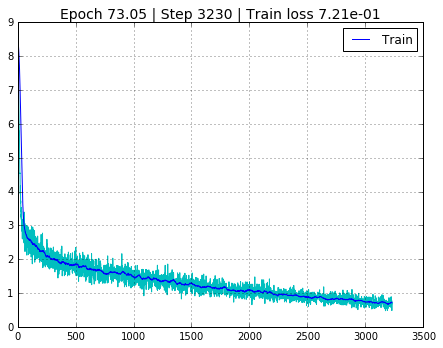

CPU times: user 20min 3s, sys: 2min 5s, total: 22min 9s
Wall time: 11min 21s


In [58]:
%%time
model.train(
    step_num      = 10000,
    batch_size    = 32, 
    seq_length    = sent_len,
    learning_rate = 1e-3, 
    mean_win      = 30,
    dataset       = dataset)
model.save(model_path)

## Test

In [63]:
batch_size = 3
inp = dataset.get_next_batch(batch_size)
for s in inp:
    print('[%s]' % dataset.decode(s).replace(' _', ''))
out = model.run(inp, batch_size, sent_len)
print('-'*100)
for s in out:
    print('[%s]' % dataset.decode(s).replace(' _', ''))


[<BOS> промачивал ноги , мок под дождем и , наконец , слег в постель , с которой не вставал уже более он умер в глубокую осень , в конце октября месяца . <EOS>]
[<BOS> в доказательство чего дарит книги на скопленные им , в продолжение долгого времени , деньги . <EOS>]
[<BOS> не помню , что я ему отвечала . <EOS>]
----------------------------------------------------------------------------------------------------
[<BOS> однако s. , ветры под под и , наконец , вполголоса в доселе , с вполголоса не подарите уже более он своих в силах загладить , в конце копеек . <EOS>]
[<BOS> в доказательство чего месяца книги на начал им , в продолжение божий времени , деньги . <EOS>]
[<BOS> не помню , что я ему господи . <EOS>]


## Restore

In [61]:
model.restore(model_path)

INFO:tensorflow:Restoring parameters from models/rnn_autoencoder/dostoevsky-001/


In [1]:
arr=[1,2,3]

In [15]:
arr[::-1]

[3, 2, 1]